# Variational Auto-encoder

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def xavier_init(fan_in, fan_out, constant=1): 
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [4]:
class VariationalAutoencoder(object):
    def __init__(self, n_input, n_z, network_architecture, 
                 learning_rate=0.001, decoder_distribution='gaussian', 
                 reparameterization_trick=True):
        self.n_input = n_input
        self.n_z = n_z
        self.network_architecture = network_architecture
        self.learning_rate = learning_rate
        self.decoder_distribution = decoder_distribution
        self.reparameterization_trick = reparameterization_trick
        
        self.x = tf.placeholder(tf.float32, [None, n_input])
        self.x_binarized = tf.cast(tf.less_equal(tf.random_uniform(tf.shape(self.x)), self.x), 
                                   tf.float32)
        self.n_x = tf.cast(tf.shape(self.x)[1], tf.float32)
        
        self._create_network()
        
        self._create_loss_optimizer()
        
        init = tf.initialize_all_variables()
        self.saver = tf.train.Saver(self.flat_weights, max_to_keep=None)
        
        self.sess = tf.Session()
        self.sess.run(init)
        
    def _create_network(self):
        self.weights = self._initialize_weights(**self.network_architecture)
        
        encoder_layer1 = tf.nn.softplus(tf.add(tf.matmul(self.x_binarized, self.weights['encoder']['h1']),
                                               self.weights['encoder']['b1']))
        encoder_layer2 = tf.nn.softplus(tf.add(tf.matmul(encoder_layer1, self.weights['encoder']['h2']), 
                                               self.weights['encoder']['b2']))
        self.z_mean = tf.add(tf.matmul(encoder_layer2, self.weights['encoder']['out_mean']), 
                             self.weights['encoder']['out_mean_b'])
        self.z_log_sigma_sq = tf.add(tf.matmul(encoder_layer2, self.weights['encoder']['out_log_sigma_sq']), 
                                     self.weights['encoder']['out_log_sigma_sq_b'])
        if self.reparameterization_trick == True:
            epsilon = tf.random_normal((tf.shape(self.x)[0], self.n_z), 0, 1, dtype=tf.float32)
            self.z = tf.add(self.z_mean, tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), epsilon))
        else:
            self.z = tf.random_normal((tf.shape(self.x)[0], self.n_z), 
                                      self.z_mean, tf.sqrt(tf.exp(self.z_log_sigma_sq)), dtype=tf.float32)
            self.z = tf.stop_gradient(self.z)
        
        decoder_layer1 = tf.nn.softplus(tf.add(tf.matmul(self.z, self.weights['decoder']['h1']),
                                               self.weights['decoder']['b1']))
        decoder_layer2 = tf.nn.softplus(tf.add(tf.matmul(decoder_layer1, self.weights['decoder']['h2']), 
                                               self.weights['decoder']['b2']))
        self.x_reconstruction = tf.sigmoid(tf.add(tf.matmul(decoder_layer2, self.weights['decoder']['out_mean']),
                                                  self.weights['decoder']['out_mean_b']))
        
    def _initialize_weights(self, n_hidden_encoder_1, n_hidden_encoder_2, 
                           n_hidden_decoder_1, n_hidden_decoder_2):
        weights = dict()
        weights['encoder'] = {
            'h1': tf.Variable(xavier_init(self.n_input, n_hidden_encoder_1), name='encoder_h1'), 
            'h2': tf.Variable(xavier_init(n_hidden_encoder_1, n_hidden_encoder_2), name='encoder_h2'), 
            'out_mean': tf.Variable(xavier_init(n_hidden_encoder_2, self.n_z), name='encoder_out_mean'),
            'out_log_sigma_sq': tf.Variable(xavier_init(n_hidden_encoder_2, self.n_z), 
                                            name='encoder_out_log_sigma_sq'),
            
            'b1': tf.Variable(tf.zeros([n_hidden_encoder_1], dtype=tf.float32), name='encoder_b1'), 
            'b2': tf.Variable(tf.zeros([n_hidden_encoder_2], dtype=tf.float32), name='encoder_b2'), 
            'out_mean_b': tf.Variable(tf.zeros([self.n_z], dtype=tf.float32), name='encoder_out_mean_b'),
            'out_log_sigma_sq_b': tf.Variable(tf.zeros([self.n_z], dtype=tf.float32), 
                                              name='encoder_out_log_sigma_sq_b')
        }
        self.encoder_weights = [variable for variable in weights['encoder'].values()]
        self.encoder_weights_dict = weights['encoder']
        weights['decoder'] = {
            'h1': tf.Variable(xavier_init(self.n_z, n_hidden_decoder_1), name='decoder_h1'), 
            'h2': tf.Variable(xavier_init(n_hidden_decoder_1, n_hidden_decoder_2), name='decoder_h2'), 
            'out_mean': tf.Variable(xavier_init(n_hidden_encoder_2, self.n_input), name='decoder_out_mean'),
            
            'b1': tf.Variable(tf.zeros([n_hidden_decoder_1], dtype=tf.float32), name='decoder_b1'), 
            'b2': tf.Variable(tf.zeros([n_hidden_decoder_2], dtype=tf.float32), name='decoder_b2'), 
            'out_mean_b': tf.Variable(tf.zeros([self.n_input], dtype=tf.float32), name='decoder_out_mean_b')
        }
        self.decoder_weights = [variable for variable in weights['decoder'].values()]
        self.flat_weights = flatten(weights)
        return weights
    
    def _create_loss_optimizer(self):
        self.encoder_log_density = -0.5*self.n_z*tf.log(2*np.pi) -0.5*tf.reduce_sum(self.z_log_sigma_sq, 1) \
                                   -0.5*tf.reduce_sum(tf.mul(tf.exp(-self.z_log_sigma_sq), 
                                                             tf.square(tf.sub(self.z, self.z_mean))), 1)
        if self.decoder_distribution == 'gaussian':
            self.decoder_log_density = -0.5*self.n_x*tf.log(2*np.pi) \
                                       - 0.5*tf.reduce_sum(tf.square(tf.sub(self.x_reconstruction, self.x)), 1)
        elif self.decoder_distribution == 'bernoulli':
            self.decoder_log_density = tf.reduce_sum(self.x * tf.log(1e-8 + self.x_reconstruction) 
                                       + (1-self.x) * tf.log(1e-8 + 1 - self.x_reconstruction), 1)
        else:
            raise ValueError('Unsupported decoder distribution!')
            
        self.kl_divergency = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                                  - tf.square(self.z_mean) 
                                                  - tf.exp(self.z_log_sigma_sq), 1)
        self.cost_for_decoder_weights = tf.reduce_mean(self.kl_divergency - self.decoder_log_density)
        
        if self.reparameterization_trick == True:
            self.cost_for_encoder_weights = tf.reduce_mean(self.kl_divergency - self.decoder_log_density)
        else:
            self.non_reparameterization_cost = -tf.mul(self.encoder_log_density, self.decoder_log_density)
            self.cost_for_encoder_weights = tf.reduce_mean(self.kl_divergency + self.non_reparameterization_cost)
        
        self.cost_for_display = tf.reduce_mean(self.kl_divergency - self.decoder_log_density)
        self.decoder_optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.decoder_minimizer = self.decoder_optimizer.minimize(self.cost_for_decoder_weights, 
                                                                 var_list=self.decoder_weights)
        
        self.encoder_optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.encoder_minimizer = self.encoder_optimizer.minimize(self.cost_for_encoder_weights, 
                                                                 var_list=self.encoder_weights)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.decoder_gradients = self.optimizer.compute_gradients(self.cost_for_decoder_weights, 
                                                                  var_list=self.decoder_weights)
        self.encoder_gradients = self.optimizer.compute_gradients(self.cost_for_encoder_weights, 
                                                                  var_list=self.encoder_weights)
        
    def partial_fit(self, X):
        self.sess.run(self.decoder_minimizer, feed_dict={self.x: X})
        self.sess.run(self.encoder_minimizer, feed_dict={self.x: X})
    
    def get_decoder_gradients(self, X):
        gradients = self.sess.run(self.decoder_gradients, feed_dict={self.x: X})
        flat_gradients = np.array([])
        for grad in gradients:
            flat_gradients = np.append(flat_gradients, grad[0].flatten())
        return flat_gradients
    
    def get_encoder_gradients(self, X):
        gradients = self.sess.run(self.encoder_gradients, feed_dict={self.x: X})
        flat_gradients = np.array([])
        for grad in gradients:
            flat_gradients = np.append(flat_gradients, grad[0].flatten())
        return flat_gradients
    
    def get_decoder_log_density(self, X):
        return self.sess.run(tf.reduce_mean(self.decoder_log_density), feed_dict={self.x: X})
    
    def transform(self, X):
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z=None):
        if z is None:
            z = np.random.normal(size=self.n_z)
        return self.sess.run(self.x_reconstruction, feed_dict={self.z: z})
    
    def reconstruct(self, X):
        return self.sess.run(self.x_reconstruction, feed_dict={self.x: X})
    
    def loss(self, X):
        return self.sess.run(self.cost_for_display, feed_dict={self.x: X})
    
    def save_weights(self, save_path):
        self.saver.save(self.sess, save_path)
        
    def restore_weights(self, restore_path):
        self.saver.restore(self.sess, restore_path)

In [5]:
def get_gradient_mean_and_std(vae, batch_xs, n_iterations, gradient_type):
    gradients = []
    for _ in xrange(n_iterations):
        if gradient_type == 'decoder':
            gradient = vae.get_decoder_gradients(batch_xs)
        elif gradient_type == 'encoder':
            gradient = vae.get_encoder_gradients(batch_xs)
        gradients.append(gradient)
    gradients = np.array(gradients)
    gradient_std = np.linalg.norm(gradients - gradients.mean(axis=0)) / np.sqrt(n_iterations)
    return gradients.mean(axis=0), gradient_std

def train(data, n_samples, n_input, n_z, batch_size, 
          network_architecture, learning_rate, decoder_distribution, 
          reparameterization_trick, training_epochs=10, display_step=5, 
          weights_save_step=5, save_weights=True, save_path='saved_weights/'):
    vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                 decoder_distribution, reparameterization_trick)
    test_loss = []
    for epoch in xrange(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        for i in xrange(total_batch):
            batch_xs, _ = data.train.next_batch(batch_size)
            vae.partial_fit(batch_xs)
            cost = vae.loss(batch_xs)
            avg_cost += cost / n_samples * batch_size
        
        test_loss.append(vae.loss(data.test.images))
        if epoch % display_step == 0:
            print('Epoch: {:04d}, cost = {:.9f}, test cost = {:.9f}' \
                  .format(epoch+1, avg_cost, test_loss[-1]))
        
        if epoch % weights_save_step == 0:
            if save_weights == True:
                vae.save_weights(save_path + '_{}'.format(epoch+1))
    test_loss = np.array(test_loss)
    return test_loss

In [39]:
n_samples = mnist.train.num_examples
n_input = 784
n_z = 20
batch_size = 128
training_epochs = 501
display_step = 25
weights_save_step = 25

network_architecture = {
    'n_hidden_encoder_1': 80,
    'n_hidden_encoder_2': 80,
    'n_hidden_decoder_1': 80,
    'n_hidden_decoder_2': 80
}

In [7]:
learning_rate = 1e-3

In [8]:
RT_loss = train(mnist, n_samples, n_input, n_z, 
                batch_size, network_architecture, 
                learning_rate, decoder_distribution='bernoulli', 
                reparameterization_trick=True, 
                training_epochs=training_epochs,
                display_step=display_step,
                weights_save_step=weights_save_step, 
                save_weights = True, 
                save_path = 'saved_weights/reparameterization_trick')

Epoch: 0001, cost = 203.319989631, test cost = 176.522735596
Epoch: 0026, cost = 110.720315163, test cost = 110.137763977
Epoch: 0051, cost = 107.923367312, test cost = 107.658615112
Epoch: 0076, cost = 106.697424893, test cost = 106.415496826
Epoch: 0101, cost = 105.973777788, test cost = 105.970901489
Epoch: 0126, cost = 105.410312464, test cost = 105.440216064
Epoch: 0151, cost = 105.116743093, test cost = 105.099937439
Epoch: 0176, cost = 104.841534606, test cost = 104.856452942
Epoch: 0201, cost = 104.639970170, test cost = 104.718544006
Epoch: 0226, cost = 104.414357475, test cost = 104.550140381
Epoch: 0251, cost = 104.249149627, test cost = 104.331809998
Epoch: 0276, cost = 104.098889080, test cost = 104.297546387
Epoch: 0301, cost = 103.962532244, test cost = 103.955513000
Epoch: 0326, cost = 103.884636115, test cost = 104.055404663
Epoch: 0351, cost = 103.739817791, test cost = 103.984260559
Epoch: 0376, cost = 103.620947053, test cost = 103.842338562
Epoch: 0401, cost = 103.

In [18]:
learning_rate = 1e-4

In [19]:
LDT_loss = train(mnist, n_samples, n_input, n_z, 
                batch_size, network_architecture, 
                learning_rate, decoder_distribution='bernoulli', 
                reparameterization_trick=False, 
                training_epochs=training_epochs, 
                display_step=display_step,
                weights_save_step=weights_save_step, 
                save_weights = True, 
                save_path = 'saved_weights/log_derivative_trick')

Epoch: 0001, cost = 305.696887571, test cost = 223.562896729
Epoch: 0026, cost = 181.485630504, test cost = 179.431869507
Epoch: 0051, cost = 160.218705007, test cost = 161.476623535
Epoch: 0076, cost = 148.318469531, test cost = 147.959686279
Epoch: 0101, cost = 145.668837145, test cost = 145.789367676
Epoch: 0126, cost = 140.670892507, test cost = 139.738830566
Epoch: 0151, cost = 138.313772337, test cost = 137.518493652
Epoch: 0176, cost = 137.615402308, test cost = 136.424041748
Epoch: 0201, cost = 137.368574627, test cost = 136.721252441
Epoch: 0226, cost = 135.471907227, test cost = 134.757324219
Epoch: 0251, cost = 133.723923260, test cost = 133.144226074
Epoch: 0276, cost = 133.645774219, test cost = 133.330871582
Epoch: 0301, cost = 133.485310440, test cost = 132.913909912
Epoch: 0326, cost = 132.667313636, test cost = 131.618865967
Epoch: 0351, cost = 132.068268572, test cost = 131.589294434
Epoch: 0376, cost = 131.783814258, test cost = 131.595031738
Epoch: 0401, cost = 129.

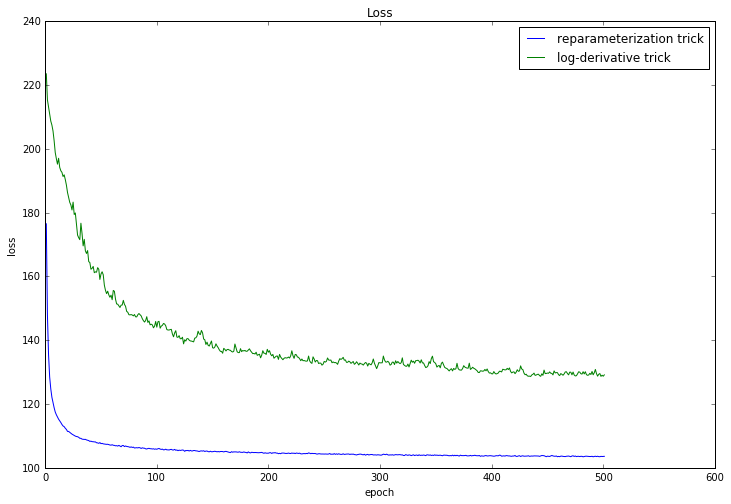

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, RT_loss.shape[0]+1), RT_loss, label='reparameterization trick')
plt.plot(np.arange(1, LDT_loss.shape[0]+1), LDT_loss, label='log-derivative trick')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')

## Stds of gradients

In [40]:
batch_xs, _ = mnist.train.next_batch(batch_size)
n_iterations = 100

### Stds for reparameterization trick weights

#### Reparameterization trick (RT) stds

In [41]:
RT_encoder_stds = []
RT_decoder_stds = []
vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                             decoder_distribution='bernoulli', reparameterization_trick=True)
for saved_index in range(1, training_epochs, weights_save_step):
    vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    RT_encoder_stds.append(encoder_std)
    RT_decoder_stds.append(decoder_std)

#### Log-derivative trick (LDT) stds

In [42]:
LDT_encoder_stds = []
LDT_decoder_stds = []
vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                             decoder_distribution='bernoulli', reparameterization_trick=False)
for saved_index in range(1, training_epochs, weights_save_step):
    vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    LDT_encoder_stds.append(encoder_std)
    LDT_decoder_stds.append(decoder_std)

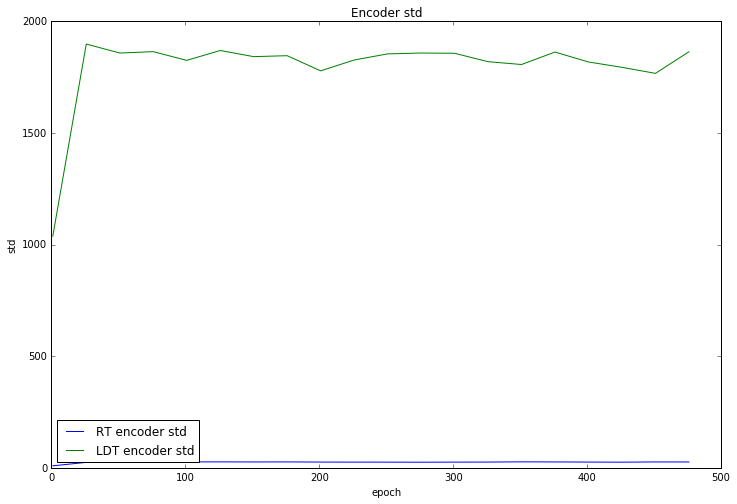

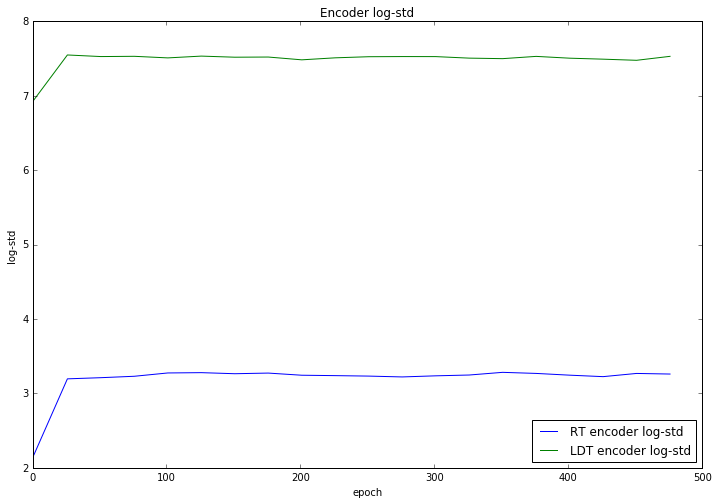

In [43]:
plt.figure(0, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs, weights_save_step), RT_encoder_stds, label='RT encoder std')
plt.plot(np.arange(1, training_epochs, weights_save_step), LDT_encoder_stds, label='LDT encoder std')
plt.title('Encoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')
plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs, weights_save_step), np.log(RT_encoder_stds), label='RT encoder log-std')
plt.plot(np.arange(1, training_epochs, weights_save_step), np.log(LDT_encoder_stds), label='LDT encoder log-std')
plt.title('Encoder log-std')
plt.xlabel('epoch')
plt.ylabel('log-std')
plt.legend(loc='best')

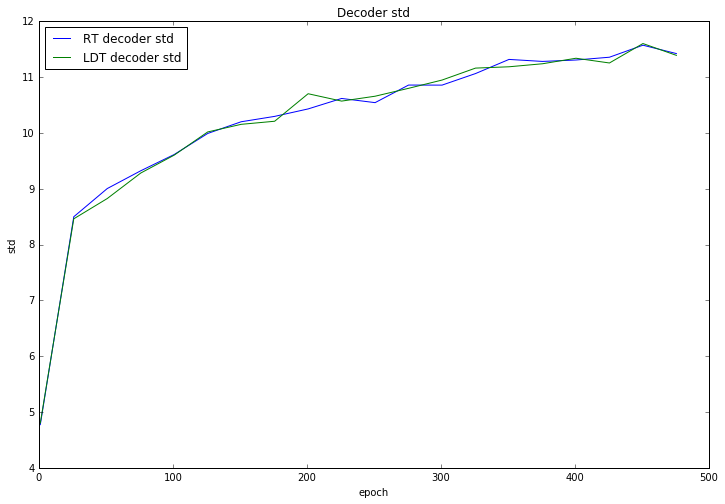

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, training_epochs, weights_save_step), RT_decoder_stds, label='RT decoder std')
plt.plot(np.arange(1, training_epochs, weights_save_step), LDT_decoder_stds, label='LDT decoder std')
plt.title('Decoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')

### Stds for log-derivative trick weights

#### Reparameterization trick (RT) stds

In [45]:
RT_encoder_stds = []
RT_decoder_stds = []
vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                             decoder_distribution='bernoulli', reparameterization_trick=True)
for saved_index in range(1, training_epochs, weights_save_step):
    vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    RT_encoder_stds.append(encoder_std)
    RT_decoder_stds.append(decoder_std)

#### Log-derivative trick (LDT) stds

In [46]:
LDT_encoder_stds = []
LDT_decoder_stds = []
vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                             decoder_distribution='bernoulli', reparameterization_trick=False)
for saved_index in range(1, training_epochs, weights_save_step):
    vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
    _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
    LDT_encoder_stds.append(encoder_std)
    LDT_decoder_stds.append(decoder_std)

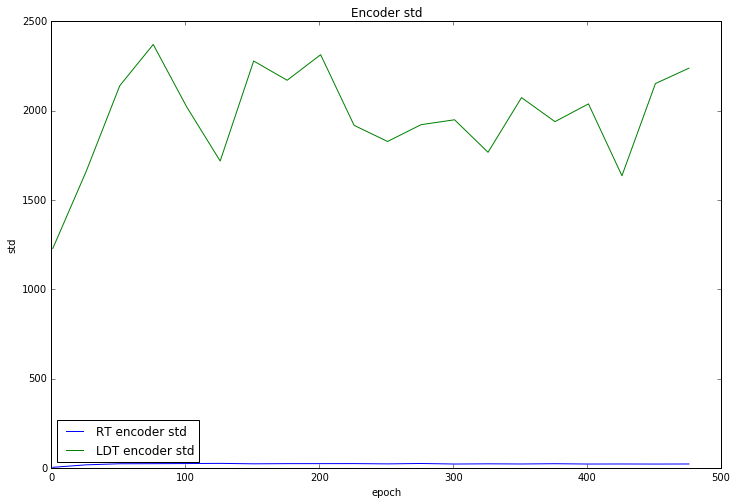

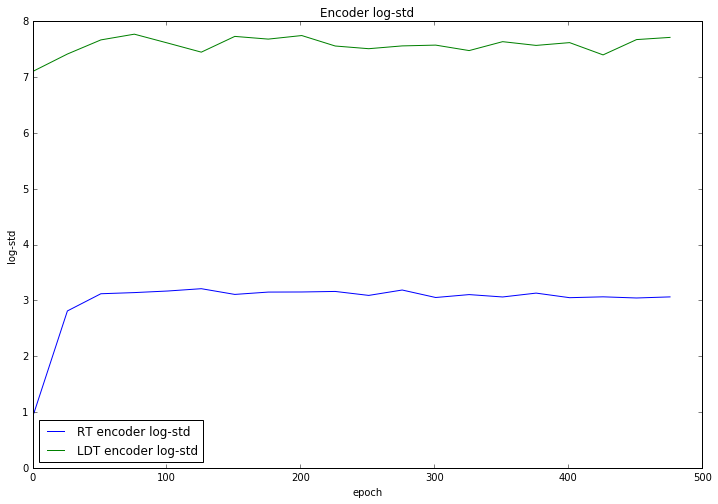

In [47]:
plt.figure(0, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs, weights_save_step), RT_encoder_stds, label='RT encoder std')
plt.plot(np.arange(1, training_epochs, weights_save_step), LDT_encoder_stds, label='LDT encoder std')
plt.title('Encoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')
plt.figure(1, figsize=(12, 8))
plt.plot(np.arange(1, training_epochs, weights_save_step), np.log(RT_encoder_stds), label='RT encoder log-std')
plt.plot(np.arange(1, training_epochs, weights_save_step), np.log(LDT_encoder_stds), label='LDT encoder log-std')
plt.title('Encoder log-std')
plt.xlabel('epoch')
plt.ylabel('log-std')
plt.legend(loc='best')

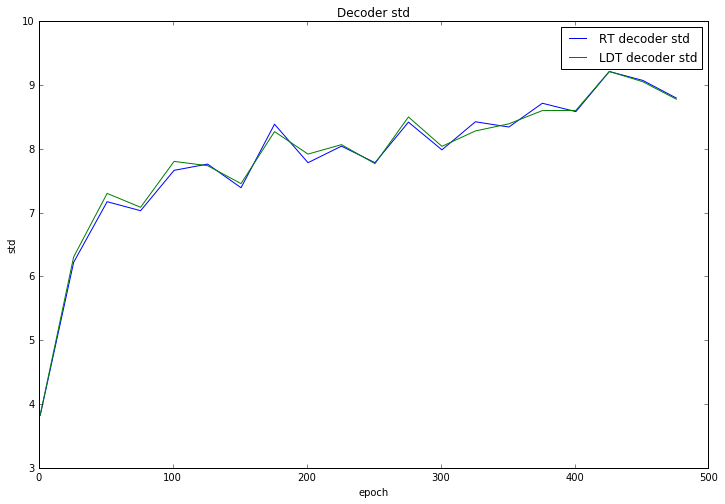

In [48]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, training_epochs, weights_save_step), RT_decoder_stds, label='RT decoder std')
plt.plot(np.arange(1, training_epochs, weights_save_step), LDT_decoder_stds, label='LDT decoder std')
plt.title('Decoder std')
plt.xlabel('epoch')
plt.ylabel('std')
plt.legend(loc='best')

## Difference between the means of gradients

In [30]:
min_iterations = 1000
max_iterations = 10001
step = 1000
weights_save_step = 250

### Reparameterization trick weights

In [31]:
encoder_gradients_delta = {}
rt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                decoder_distribution='bernoulli', reparameterization_trick=True)
ldt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                 decoder_distribution='bernoulli', reparameterization_trick=False)
for saved_index in range(1, training_epochs, weights_save_step):
    encoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    rt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    ldt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    for n_iterations in range(min_iterations, max_iterations, step):
        rt_mean, _ = get_gradient_mean_and_std(rt_vae, batch_xs, n_iterations, 'encoder')
        ldt_mean, _ = get_gradient_mean_and_std(ldt_vae, batch_xs, n_iterations, 'encoder')
        encoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - ldt_mean))
    print('epoch_{}'.format(saved_index))

epoch_1
epoch_251


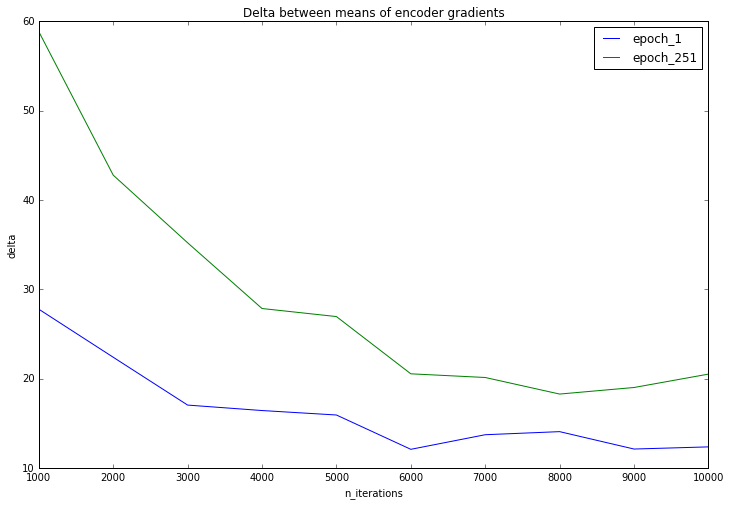

In [32]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             encoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of encoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')

In [33]:
decoder_gradients_delta = {}
rt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                decoder_distribution='bernoulli', reparameterization_trick=True)
ldt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                 decoder_distribution='bernoulli', reparameterization_trick=False)
for saved_index in range(1, training_epochs, weights_save_step):
    decoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    rt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    ldt_vae.restore_weights('saved_weights/reparameterization_trick_{}'.format(saved_index))
    for n_iterations in range(min_iterations, max_iterations, step):
        rt_mean, _ = get_gradient_mean_and_std(rt_vae, batch_xs, n_iterations, 'decoder')
        ldt_mean, _ = get_gradient_mean_and_std(ldt_vae, batch_xs, n_iterations, 'decoder')
        decoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - ldt_mean))

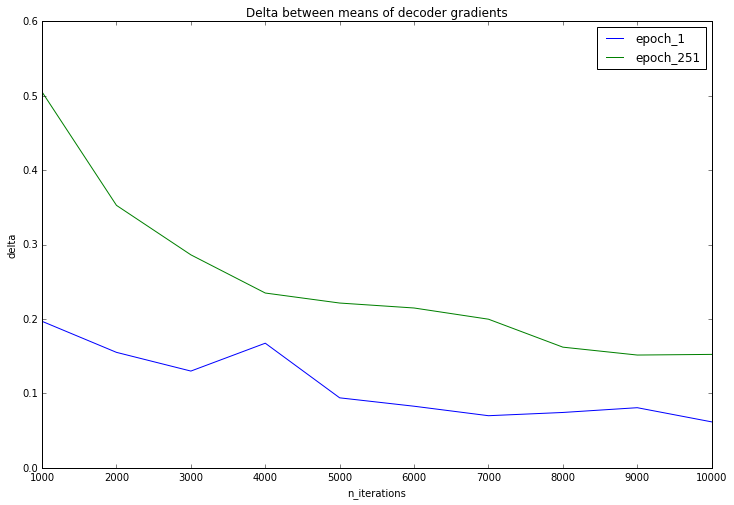

In [34]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             decoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of decoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')

### Log-derivative trick weights

In [35]:
encoder_gradients_delta = {}
rt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                decoder_distribution='bernoulli', reparameterization_trick=True)
ldt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                 decoder_distribution='bernoulli', reparameterization_trick=False)
for saved_index in range(1, training_epochs, weights_save_step):
    encoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    rt_vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    ldt_vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    for n_iterations in range(min_iterations, max_iterations, step):
        rt_mean, _ = get_gradient_mean_and_std(rt_vae, batch_xs, n_iterations, 'encoder')
        ldt_mean, _ = get_gradient_mean_and_std(ldt_vae, batch_xs, n_iterations, 'encoder')
        encoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - ldt_mean))

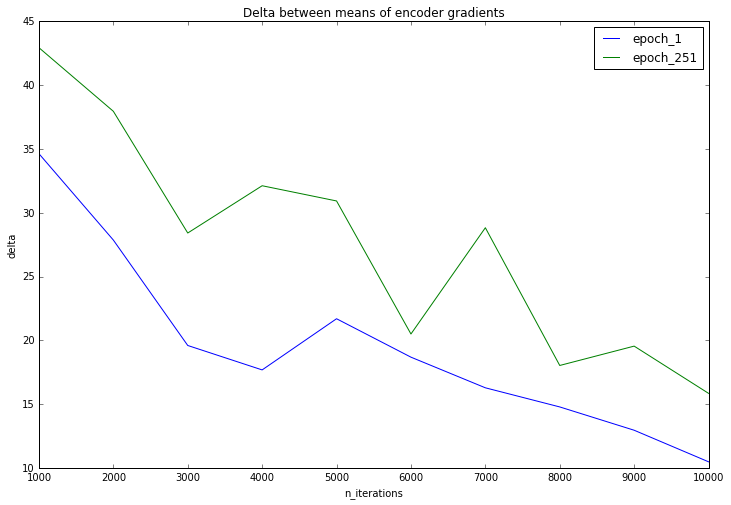

In [36]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             encoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of encoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')

In [37]:
decoder_gradients_delta = {}
rt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                decoder_distribution='bernoulli', reparameterization_trick=True)
ldt_vae = VariationalAutoencoder(n_input, n_z, network_architecture, learning_rate, 
                                 decoder_distribution='bernoulli', reparameterization_trick=False)
for saved_index in range(1, training_epochs, weights_save_step):
    decoder_gradients_delta['epoch_{}'.format(saved_index)] = []
    rt_vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    ldt_vae.restore_weights('saved_weights/log_derivative_trick_{}'.format(saved_index))
    for n_iterations in range(min_iterations, max_iterations, step):
        rt_mean, _ = get_gradient_mean_and_std(rt_vae, batch_xs, n_iterations, 'decoder')
        ldt_mean, _ = get_gradient_mean_and_std(ldt_vae, batch_xs, n_iterations, 'decoder')
        decoder_gradients_delta['epoch_{}'.format(saved_index)].append(np.linalg.norm(rt_mean - ldt_mean))

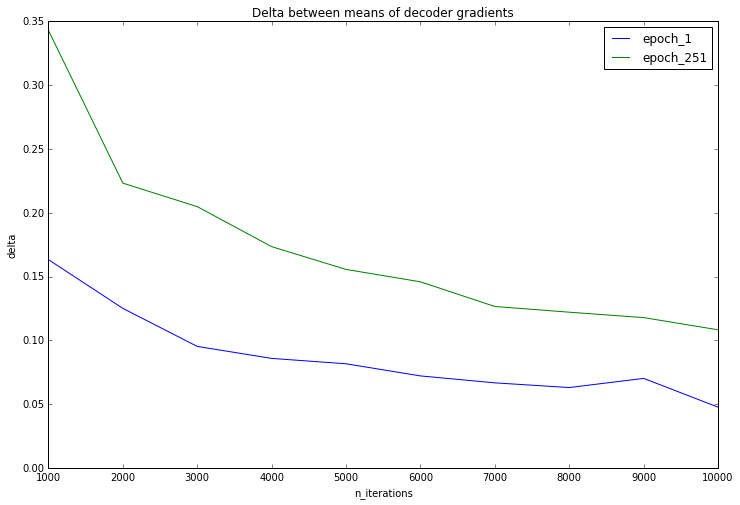

In [38]:
plt.figure(figsize=(12, 8))
for saved_index in range(1, training_epochs, weights_save_step):
    plt.plot(np.arange(min_iterations, max_iterations, step), 
             decoder_gradients_delta['epoch_{}'.format(saved_index)], label='epoch_{}'.format(saved_index))
plt.title('Delta between means of decoder gradients')
plt.xlabel('n_iterations')
plt.ylabel('delta')
plt.legend(loc='best')